In [1]:
%%capture
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
!pip install openpyxl
import os

In [2]:
actual_path = os.getcwd()
os.chdir('/home/onyxia/work/material_science/Spetral_clustering')
%run rbf.ipynb
os.chdir(actual_path)

In [3]:
max_calculated = pd.read_csv('max_calculated.csv')
max_elemental = pd.read_csv('max_elemental.csv')
list_mxene = pd.read_excel('synthesized-MXenes-MAX.xlsx',sheet_name=0)
list_failed = pd.read_excel('synthesized-MXenes-MAX.xlsx', sheet_name=2)
n_samples = max_elemental.shape[0]
synth_list = pd.unique(list_mxene['MXene'])[:-1]
to_drop = list(range(167,173))
mx_ene_df = list_mxene.drop(labels = to_drop, axis='index')
mx_ene_df = mx_ene_df.drop(['Unnamed: 9','Unnamed: 12','Notes','status','Reference method'],axis=1)
max_elemental['class'] = np.zeros(max_elemental.shape[0])
parents = mx_ene_df['Parent material'].unique()
banned_words = ['+','Mxene','topochemical','reaction', 'or',
               'synthesis','MXene','direct']
complete_parents = []
for i in range(len(parents)):
    inter = parents[i].split()
    for word in range(len(inter)):
        if inter[word] not in banned_words:
            complete_parents.append(inter[word])


for i in range(max_elemental.shape[0]):
    if max_elemental.loc[i,'compound_formula'] in complete_parents:
        max_elemental.loc[i,'class'] = 1

max_elemental = max_elemental.set_index('compound_formula',drop=True)
max_calculated = max_calculated.set_index('prettyformula',drop=True)
whole_data = max_elemental.copy()


M_elements = pd.get_dummies(whole_data['M_element'],prefix='M',dtype=float)
A_elements = pd.get_dummies(whole_data['A_element'],prefix='A',dtype=float)
X_elements = pd.get_dummies(whole_data['X_element'],prefix='X',dtype=float)
whole_data = whole_data.drop(['M_element','A_element','X_element'],axis=1)
x_group = pd.get_dummies(whole_data['X_X_group'],prefix='x_g',dtype=float)
a_group = pd.get_dummies(whole_data['A_A_group'],prefix='a_g',dtype=float)
m_group = pd.get_dummies(whole_data['M_M_group'],prefix='m_g',dtype=float)
whole_data = whole_data.drop(['X_X_group','A_A_group','M_M_group'],axis=1)
whole_data = pd.concat([whole_data,M_elements,A_elements,X_elements,x_group,
                       a_group,m_group],axis=1)

test_tree = DecisionTreeClassifier().fit(X=whole_data.drop(['class'],axis=1),
                                                              y=whole_data['class'])

imp_feat = test_tree.feature_importances_
names_feat = test_tree.feature_names_in_

imp_feat = imp_feat.reshape(-1,1)
names_feat = names_feat.reshape(-1,1)
test_df = pd.DataFrame(np.hstack((names_feat,imp_feat)))
test_df.columns = ['names_feat','imp_feat']
test_df = test_df.set_index('names_feat',drop=True)
test_df = test_df[test_df['imp_feat'] > 0]

diff_z = list(test_df.index)


number_of_atoms = np.zeros(n_samples)
compteur = 0
for element in whole_data.index:
    inter = []
    for cara in element:
        if cara in list(str(1234567890)):
            inter.append(cara)
    if len(inter) == 1:
        number_of_atoms[compteur] = int(inter[0]) + 2
    elif len(inter) == 2:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + 1
    elif len(inter) == 3:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + int(inter[2])
    compteur += 1

columns_name = whole_data.drop(['class'],axis=1).columns.copy()
normalized = whole_data.drop(['class'],axis=1).to_numpy()/number_of_atoms.reshape(-1,1)

data_norm = pd.DataFrame(normalized)
data_norm.columns = columns_name
data_norm['compound_name'] = whole_data.index
data_norm = data_norm.set_index('compound_name',drop=True)

data_norm = data_norm.filter(items=list(diff_z),axis=1)
data_norm['class'] = whole_data['class'].copy()

retained_features = list(test_df.index)

for feat in diff_z:
    if len(feat) > 5:
        retained_features.remove(feat)

list_dummies = []

for i in retained_features:
    if 'M_' in i:
        list_dummies.append(i)
    elif 'A_' in i:
        list_dummies.append(i)
    elif 'X_' in i:
        list_dummies.append(i)

for col in list_dummies:
    for row in data_norm.index:
        if data_norm.loc[row,col] != 0:
            data_norm.loc[row,col] = 1

for i in data_norm.index:
    if data_norm.loc[i,'class'] == 0:
        data_norm.loc[i,'class'] = -1

<Axes: xlabel='names_feat'>

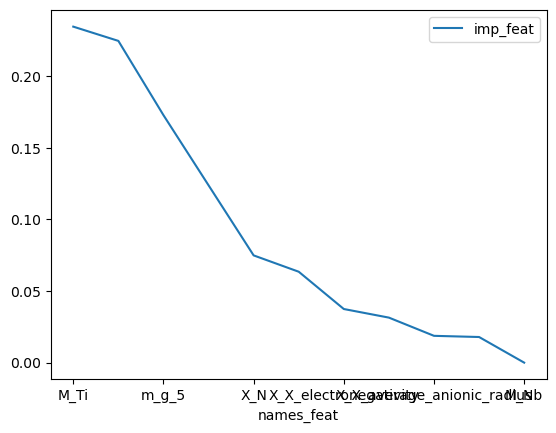

In [11]:
test_df.sort_values(by='imp_feat',ascending=False).plot()

In [12]:
test_df.sort_values(by='imp_feat',ascending=False)

,imp_feat
names_feat,
M_Ti,0.234659
X_X_average_ionic_radius,0.224706
m_g_5,0.172851
A_A_density,0.123867
X_N,0.074902
A_Zn,0.063495
X_X_electronegativity,0.037451
A_A_average_cationic_radius,0.031445
X_X_average_anionic_radius,0.018725


In [13]:
very_positive_instances = data_norm[data_norm['class'] == 1].copy()
very_positive_instances['pred'] = np.zeros(15)
list_of_positive_part = list(very_positive_instances.index)

In [14]:
list_wo_class = list(data_norm.columns)
list_wo_class.remove('class')
df_whole_results = data_norm.drop(list_wo_class,axis=1)
t=15
count_elem = 0
n_positives = very_positive_instances.shape[0]-1
for part_element in list_of_positive_part:
    data = data_norm.drop(part_element,axis=0).copy()
    df_results = data.drop(list(data.columns),axis=1)
    positive_instances = data[data['class'] == 1]
    index_of_positive = list(positive_instances.index)
    unlabelled_instances = data.drop(labels=index_of_positive,axis=0)
    avg_element = np.zeros(t)
    for i in range(t):
        u_t = unlabelled_instances.sample(n=n_positives)
        training_set = pd.concat([positive_instances,u_t])
        training_index = list(training_set.index)
        clf = SVC().fit(X=training_set.drop(['class'],axis=1).to_numpy(),y=training_set['class'].to_numpy())
        interm_df = data.drop(labels=training_index,axis=0)
        interm_df['predictions'] = clf.decision_function(X=interm_df.drop(['class'],axis=1).to_numpy())
        df_for_merge = pd.DataFrame(interm_df['predictions'])
        df_for_merge.columns = [f'score_{i},{count_elem}']
        df_results = df_results.merge(df_for_merge, how='left', left_index=True, right_index=True)
        avg_element[i] = clf.decision_function(X=data_norm.drop(['class'],axis=1).loc[part_element,:].to_numpy().reshape(1,-1))[0]
    very_positive_instances.loc[part_element,'pred'] = np.mean(avg_element)
    df_whole_results = df_whole_results.merge(df_results,how='left',left_index=True,right_index=True)
    count_elem += 1

In [15]:
avg_results = df_whole_results.drop(['class'],axis=1).mean(axis=1)

In [18]:
very_positive_instances['pred_bis'] = np.sign(very_positive_instances['pred'])

In [19]:
for_recall = very_positive_instances['pred_bis'].to_numpy()

In [20]:
true_positives = 0
for i in range(15):
    if for_recall[i] == 1:
        true_positives += 1

In [21]:
recall = true_positives/15
df_whole_results = df_whole_results.drop(['class'],axis=1)
df_avg = df_whole_results.mean(axis=1)
df_avg = pd.DataFrame(df_avg)
df_avg.columns = ['avg']
df_avg['decision'] = np.sign(df_avg['avg'])
predicted_positives = df_avg.groupby('decision').count().loc[1.,'avg']
proba_pos_pred = predicted_positives/data_norm.shape[0]
weird_metric = (recall**2)/proba_pos_pred

In [22]:
recall

0.9333333333333333

In [23]:
weird_metric

np.float64(4.62547730829421)

In [24]:
proba_pos_pred

np.float64(0.1883289124668435)

In [25]:
df_whole_np = df_whole_results.to_numpy()
avg_df = np.zeros((2262,15))
for i in range(15):
    avg_df[:,i] = np.nanmean(df_whole_np[:,14*i:14*(i+1)],axis=1)

avg_df = (np.sign(avg_df)+1)/2
avg_proba = np.nanmean(avg_df)
weird_metric = recall/avg_proba
weird_metric

/tmp/ipykernel_7906/1300291536.py:4: RuntimeWarning: Mean of empty slice
  avg_df[:,i] = np.nanmean(df_whole_np[:,14*i:14*(i+1)],axis=1)


np.float64(4.957138354869209)

In [26]:
avg_proba

np.float64(0.18828067052366118)